In [48]:
import os 
os.chdir('/home/xinglong/git_local/ssm-jax')

from ssm_jax.distributions import niw_posterior_update, mniw_posterior_update
from ssm_jax.linear_gaussian_ssm.inference import LGSSMParams, lgssm_posterior_sample, lgssm_smoother


In [49]:
from jax import random as  jr
from jax import numpy as jnp
from jax import lax, vmap

from ssm_jax.distributions import NormalInverseWishart as NIW, MatrixNormalInverseWishart as MNIW
from ssm_jax.linear_gaussian_ssm.models import LinearGaussianSSM
from ssm_jax.linear_gaussian_ssm.blocked_gibbs import blocked_gibbs

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [16, 9]

/home/xinglong/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


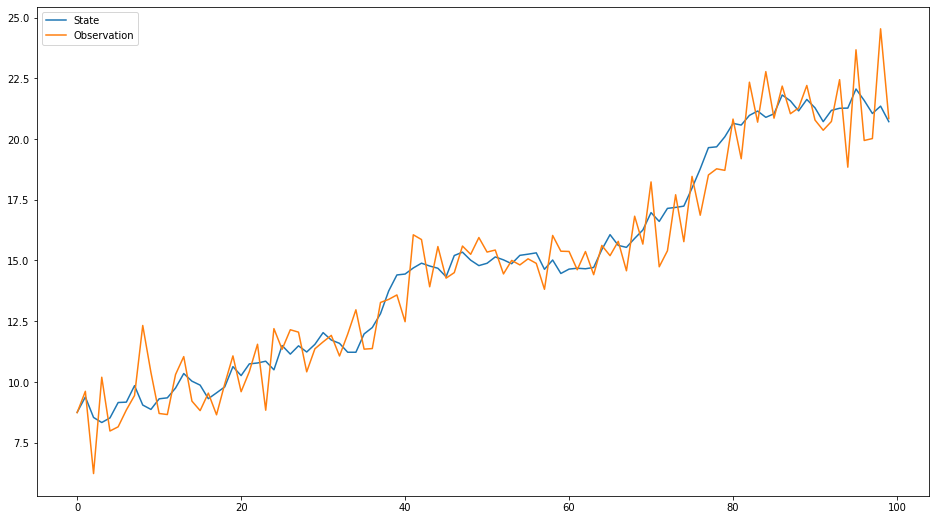

In [50]:
# Generate synthetic observations

from cProfile import label


num_timesteps=100
key=jr.PRNGKey(0)

# Set the dimension of the system
D_obs = 1
D_hid = 1

# Set true value of the parameter
sigma_dynamics = 0.3
sigma_emission = 1

initial_mean = jnp.array([10])
initial_covariance = jnp.eye(D_hid)

Q = jnp.eye(D_hid) * sigma_dynamics
F = 1.01 * jnp.eye(D_hid) 

R = jnp.eye(D_obs) * sigma_emission
H = jnp.ones((D_obs, D_hid))

# Generate the observation
lgssm = LinearGaussianSSM(initial_mean=initial_mean,
                          initial_covariance=initial_covariance,
                          dynamics_matrix=F,
                          dynamics_covariance=Q,
                          emission_matrix=H,
                          emission_covariance=R) 

states, observations = lgssm.sample(key, num_timesteps)
plt.plot(states, label='State')
plt.plot(observations, label='Observation')
plt.legend()

In [54]:
# Sample

sample_size=1000
log_probs, samp_params = blocked_gibbs(key, sample_size, observations, D_hid)

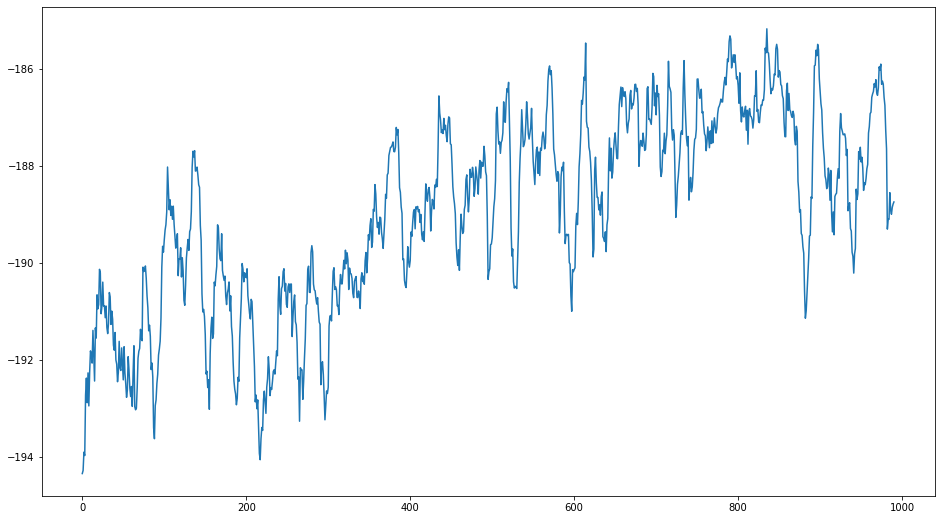

In [55]:
# Plot the log probability curve 
# (averaged over 50 consecutive iterations to smooth the curve)

k=10
import numpy as np
log_prob_smoothed = np.convolve(log_probs, np.ones(k)/k, 'valid')
plt.plot(log_prob_smoothed)

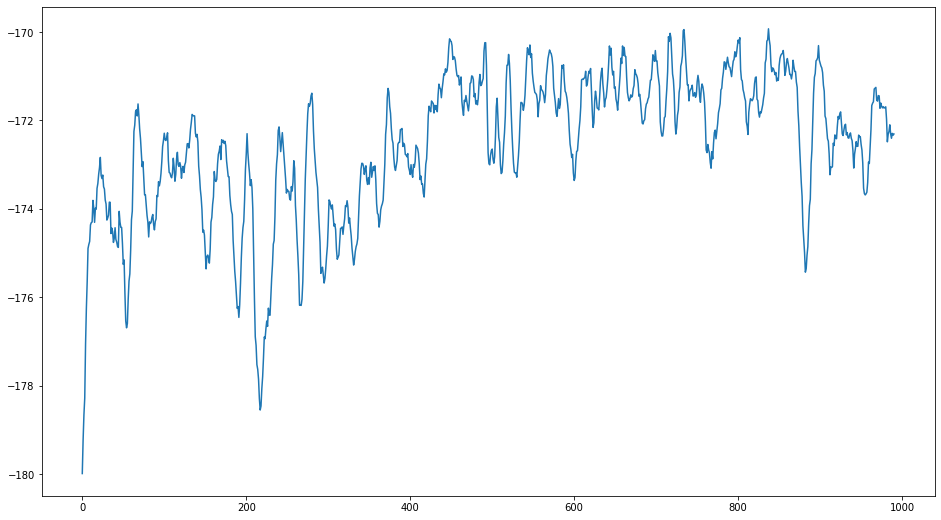

In [56]:
# Implement kalman smoother using samples of parameters

smoothed_posterior = vmap(lgssm_smoother, in_axes=(0, None, None))(samp_params, observations, None)
log_prob_smoothed_states = smoothed_posterior.marginal_loglik
k=10
log_prob_smoothed = np.convolve(log_prob_smoothed_states, np.ones(k)/k, 'valid')
plt.plot(log_prob_smoothed)

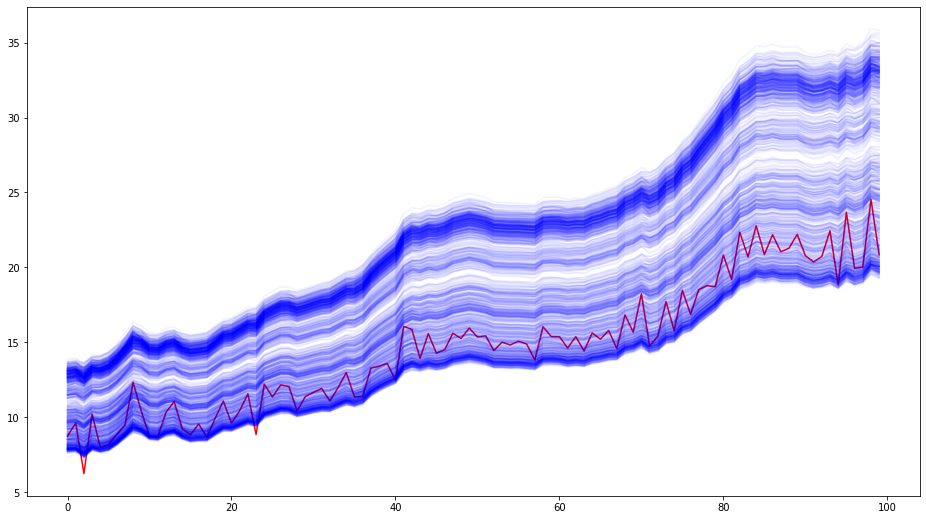

In [58]:
# Nonidentifiability of parameters

plt.plot(observations, color='red')
plt.plot(smoothed_posterior.smoothed_means[:,:,0].T, alpha=0.05, color='blue')